# Training Demo Enformer Celltyping

This workbook steps through training Enformer Celltyping using the small subset of data available in the repo.

## Step 1 Create pre-trained enformer model 

The enformer model available from tensorflow hub needs to be downloaded, the weights
lifted and added to a recreated enformer model with the final layers after the attention
layers removed.

In [ ]:
#create Enformer Celltyping - for training
from EnformerCelltyping.enf_celltyping import Enformer_Celltyping
from EnformerCelltyping.utils import pearsonR
import tensorflow as tf

assays = ['h3k27ac', 'h3k4me1', 'h3k4me3', 'h3k9me3', 'h3k27me3', 'h3k36me3']
learning_rate = 0.0002

#Using all the model default parameters for the architecture
#Set use_prebuilt_model to False since we want to train 
#Enformer Celltyping from scratch
model = Enformer_Celltyping(assays=assays,
                            use_prebuilt_model=False)
#compile the model, the model is separated into 2 channels: 
# 1. DNA channel which predicts an average histone mark score across
#    all trainig cell types
# 2. Chromatin accessibility channel which predicts the delta between
#    the average histone mark value for that region and the cell type-
#    specific one.
# Thus there are 2 loss functions
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
          loss={'avg':tf.keras.losses.poisson,
                'delta':tf.keras.losses.mean_squared_error},
          metrics=['mse',pearsonR])

#Let's view the model
model.summary()

This model does not include the layers of enformer since the DNA for the demo regions
has already been passed through the pre-trained enformer model. Since the layers are frozen 
these weights will not update so we can save on compute time and RAM by pre-running it. If
you want to build a version of Enformer Celltyping with the enformer layers run:

```
from EnformerCelltyping.constants import DATA_PATH
from EnformerCelltyping.enf_celltyping import Enformer_Celltyping

assays = ['h3k27ac', 'h3k4me1', 'h3k4me3', 'h3k9me3', 'h3k27me3', 'h3k36me3']

#Enformer Celltyping from scratch
#Include enformer layers
model = Enformer_Celltyping(assays=assays,
                            use_prebuilt_model=False,
                            enf_path = str(DATA_PATH / "enformer_model"))
```

## Step 2 Get data loader

We have include pre-computed training data with 5 cell types from EpiMap at two 
locations each in chromosome 10. We will train on these using a tensorflow data
loader.

In [ ]:
#Now let's get the data ready
from EnformerCelltyping.constants import DATA_PATH
import glob

#get links to precomputed, demo training data
#5 cell types from EpiMap at two locations each in chromosome 10
train_data = glob.glob(str(DATA_PATH/'demo/*[0-9].npz'))

In [ ]:
#Now use the provided custom data loader on this data
from EnformerCelltyping.utils import PreSavedDataGen

train_dataloader = PreSavedDataGen(files=train_data,
                                   batch_size=1)

In [ ]:
#test ouput
one_samp = next(iter(train_dataloader))
#shape of X inputs
print("X input to model shape")
print({key: dat.shape for key, dat in one_samp[0].items()})
#shape of Y inputs
print("Y output from model shape")
print({key: dat.shape for key, dat in one_samp[1].items()})

## Step 3 Train Enformer Celltyping

Now we have our data loader and model ready we can train.

In [5]:
n_epochs = 20

import datetime
strt = datetime.datetime.now()

# Train the model
model.fit(
        train_dataloader,
        epochs=n_epochs,
        verbose=2
    )


end = datetime.datetime.now()
print('Time taken: ',end-strt)

2023-02-02 18:52:24.645119: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-02 18:52:24.645578: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1996250000 Hz


Epoch 1/20
1/1 - 8s - loss: 1.0639 - avg_loss: 0.8935 - delta_loss: 0.1704 - avg_mse: 0.2573 - avg_pearsonR: -1.5055e-03 - delta_mse: 0.1704 - delta_pearsonR: 0.0162
Epoch 2/20
1/1 - 5s - loss: 1.4698 - avg_loss: 0.9503 - delta_loss: 0.5195 - avg_mse: 0.5067 - avg_pearsonR: 0.0601 - delta_mse: 0.5195 - delta_pearsonR: -1.4745e-02
Epoch 3/20
1/1 - 6s - loss: 1.2581 - avg_loss: 0.8991 - delta_loss: 0.3590 - avg_mse: 0.1963 - avg_pearsonR: 0.2065 - delta_mse: 0.3590 - delta_pearsonR: -6.2355e-03
Epoch 4/20
1/1 - 5s - loss: 1.1718 - avg_loss: 0.9126 - delta_loss: 0.2592 - avg_mse: 0.2027 - avg_pearsonR: 0.4181 - delta_mse: 0.2592 - delta_pearsonR: -1.9460e-02
Epoch 5/20
1/1 - 5s - loss: 1.0201 - avg_loss: 0.8456 - delta_loss: 0.1745 - avg_mse: 0.2953 - avg_pearsonR: 0.4423 - delta_mse: 0.1745 - delta_pearsonR: -5.6005e-03
Epoch 6/20
1/1 - 5s - loss: 1.3852 - avg_loss: 0.9260 - delta_loss: 0.4593 - avg_mse: 0.2508 - avg_pearsonR: 0.5528 - delta_mse: 0.4593 - delta_pearsonR: -1.3367e-02
Epoc

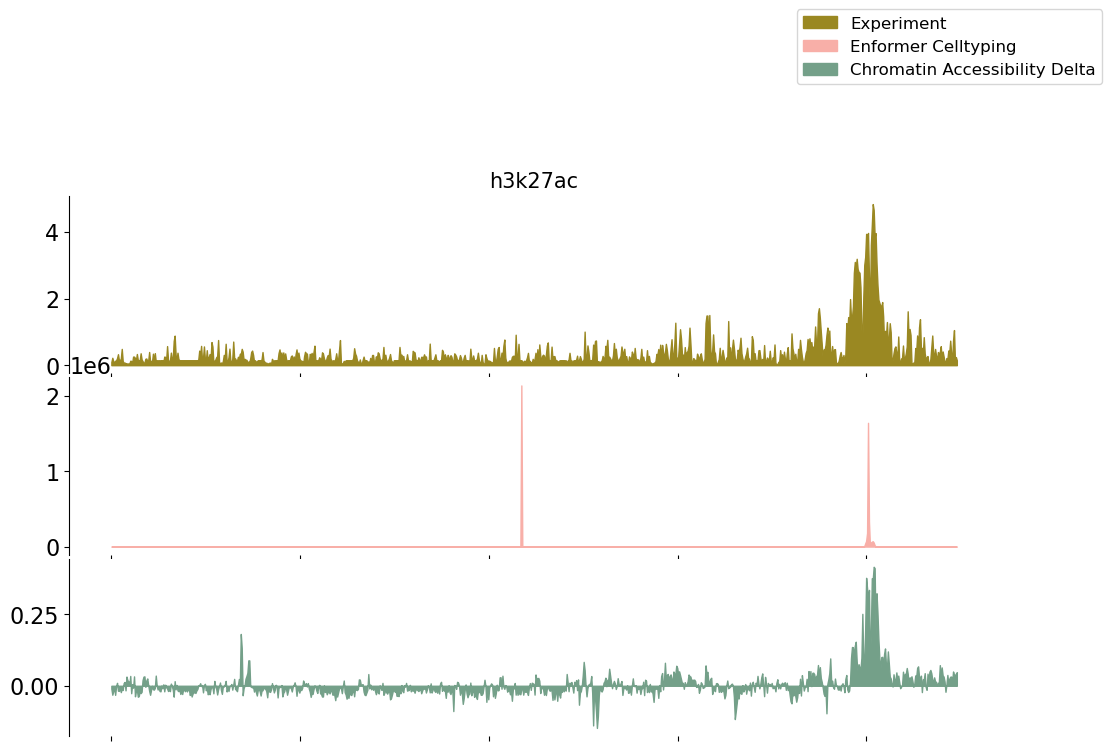

In [6]:
#Now let's predict one of the regions
#function to plot multiple tracks with the mdoel prediction, the actual and the local chrom access

#actual signal is the product of the avg and the delta
#remember this is split since the model predicts the 
#avg histone mark and then the delta in the cell type of 
#interest in two separate channels
signal = (one_samp[1]['avg']+one_samp[1]['delta']).numpy()

#We can get the local chromatin accessibility data from X
#This is the change in chromatin acessibility between the
#cell type of interest and the avg from trainig cell types.
chrom_access_lcl = one_samp[0]['chrom_access_lcl'].numpy()
#chrom access local is wider than output window so need to cut it
buff = (chrom_access_lcl.shape[1] - signal.shape[1])//2
chrom_access_lcl = chrom_access_lcl[:,buff:chrom_access_lcl.shape[1]-buff]
#now just repeat track for each plot and swap axis
import numpy as np
chrom_access_lcl = np.tile(chrom_access_lcl,[6,1]).swapaxes(0, 1)


model_pred = model.predict(one_samp[0])

from EnformerCelltyping.utils import plot_tracks
#just plot h3k27ac
plot_tracks(signal[0,:,0:1],model_pred[0,:,0:1],chrom_access_lcl[:,0:1],
            labels=['h3k27ac'],
            same_y=False,
            nme_p1='Experiment',nme_p2='Enformer Celltyping',
            nme_p3='Chromatin Accessibility Delta',
            pal =["#9A8822","#F8AFA8","#74A089"],
            figsize=(12., 6.))